## Fitting a Line

---

In this notebook, we reproduce the classic "Fitting a Model to Data" example from emcee, https://emcee.readthedocs.io/en/latest/tutorials/line/, fitting a line with uncertainties, using both emcee and ```approxposterior```. This notebook demonstrates how ```approxposterior``` can be used to perform accurate Bayesian inference of model parameters given data with uncertainties.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.optimize import minimize
import corner
import george

from approxposterior import approx, gpUtils as gpu

# Tidy up the notebook (I'm not sweeping errors under the rug, I swear!)
import warnings
warnings.filterwarnings('ignore')

/Users/dflemin3/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


**Data**

---

First, we generate data according to $y_i = m * x_i + b + \epsilon_i$ where $\epsilon_i$ are indepedent, Gaussian errors, for each measurement $i$. Then we'll plot the data to see what it looks like, with the grey line being the true, underlying model.

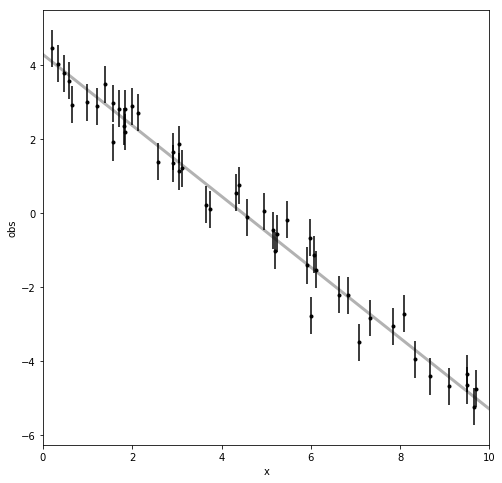

In [2]:
# Set seed for reproducibility.
np.random.seed(42)

# Choose the "true" parameters.
mTrue = -0.9594
bTrue = 4.294

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
obserr = 0.5 # Amplitude of noise term
obs = mTrue * x + bTrue # True model
obs += obserr * np.random.randn(N) # Add some random noise

# Now plot it to see what the data looks like
fig, ax = plt.subplots(figsize=(8,8))

ax.errorbar(x, obs, yerr=obserr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
ax.plot(x0, mTrue*x0+bTrue, "k", alpha=0.3, lw=3)
ax.set_xlim(0, 10)
ax.set_xlabel("x")
ax.set_ylabel("obs");

**Inference**

---

Now we want to infer posterior probability distributions for our linear model's parameters, $\theta$, i.e slope and intercept, given the data and uncertainties, D, via Bayes' Theorem: $p(\theta | D) \propto l(D | \theta)p(\theta)$ where $l(D|\theta)$ is the likelihood of the data for a given set of model parameters, and $p(\theta)$ is our assume prior probability of a given $\theta$. We sample the posterior distribution using the emcee MCMC code.  See the emcee example (https://emcee.readthedocs.io/en/latest/tutorials/line/) for more details of this procedure.

In [3]:
# Define the loglikelihood function
def logLikelihood(theta, x, obs, obserr):
  
    # Model parameters
    theta = np.array(theta)
    m, b = theta
    
    # Model predictions given parameters
    model = m * x + b
    
    # Likelihood of data given model parameters
    return -0.5*np.sum((obs-model)**2/obserr**2)

In [4]:
# Define the logprior function
def logPrior(theta):
    
    # Model parameters
    theta = np.array(theta)
    m, b = theta
    
    # Probability of model parameters: flat prior
    if -5.0 < m < 0.5 and 0.0 < b < 10.0:
        return 0.0
    return -np.inf

In [5]:
# Define logprobability function: l(D|theta) * p(theta)
def logProbability(theta, x, obs, obserr):
        
    lp = logPrior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logLikelihood(theta, x, obs, obserr)

Now that we've set up the required functions, we initialize our MCMC sampler in emcee, pick an initial state for the walkers, and run the MCMC!

In [6]:
# Randomly initialize walkers
p0 = np.random.randn(32, 2)
nwalkers, ndim = p0.shape

# Set up MCMC sample object
sampler = emcee.EnsembleSampler(nwalkers, ndim, logProbability, args=(x, obs, obserr))

# Run the MCMC for 5000 iteratios
sampler.run_mcmc(p0, 5000);

The MCMC is complete, so let's examine the joint and marginal posterior probability distributions it derived for the model parameters.

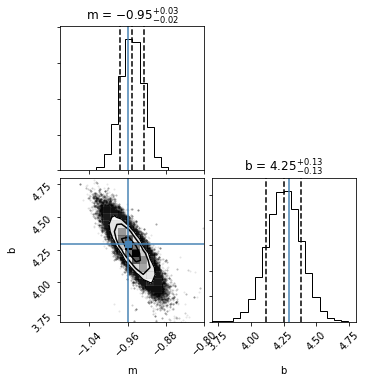

In [7]:
fig = corner.corner(sampler.flatchain,
                    quantiles=[0.16, 0.5, 0.84],
                    truths=[mTrue, bTrue],
                    labels=["m", "b"], range=([-1.1,-0.8],[3.7, 4.8]),
                    plot_contours=True, show_titles=True);

Looks good!

**Inference with ```approxposterior```**

---

Now let's see if we can derive similar constraints using ```approxposterior```.

First, ```approxposterior``` requires a function that samples model parameters from the prior distributions.

In [8]:
def sampleFunction(n):
    """
    docs

    Parameters
    ----------
    n : int
        Number of samples

    Returns
    -------
    sample : floats
        n x 3 array of floats samples from the prior
    """

    # Sample model parameters given prior distributions
    m = np.random.uniform(low=-5, high=0.5, size=(n))
    b = np.random.uniform(low=0, high=10, size=(n))
    
    return np.array([m,b]).T
# end function

Define the ```approxposterior``` parameters.

In [9]:
# Define algorithm parameters
m0 = 20                           # Initial size of training set
m = 10                            # Number of new points to find each iteration
nmax = 5                          # Maximum number of iterations
bounds = ((-5,0.5), (0.0,10.0))   # Prior bounds
algorithm = "alternate"                # Use the Kandasamy et al. (2015) formalism

# emcee MCMC parameters: Use the same MCMC parameters as the emcee-only analysis
samplerKwargs = {"nwalkers" : 32}        # emcee.EnsembleSampler parameters
mcmcKwargs = {"iterations" : 5000} # emcee.EnsembleSampler.run_mcmc parameters

# Data and uncertainties that we'll condition approxposterior on
args = (x, obs, obserr)

Here we create the initial training set by running the true forward model $m_0$ times.  ```approxposterior``` learns on this training set and, each iteration, runs the forward model $m$ additional times in regions of parameter space that will most improve its owns predictive performance, iteratively improving the posterior distribution estimate.

In [10]:
#Create a training set to condition the GP

# Randomly sample initial conditions from the prior
theta = np.array(sampleFunction(m0))

# Evaluate forward model to compute log likelihood + lnprior for each theta
y = list()
for ii in range(len(theta)):
    y.append(logLikelihood(theta[ii], *args) + logPrior(theta[ii]))
y = np.array(y)

# We'll create the initial GP using approxposterior's built-in default
# initialization.  This default typically works well in many applications.
gp = gpu.defaultGP(theta, y)

Now initialize the ```ApproxPosterior``` object and we're ready to go!

In [11]:
ap = approx.ApproxPosterior(theta=theta,                   # Initial model parameters for inputs
                            y=y,                           # Logprobability of each input
                            gp=gp,                         # Initialize Gaussian Process
                            lnprior=logPrior,              # logprior function
                            lnlike=logLikelihood,          # loglikelihood function
                            priorSample=sampleFunction,    # Prior sample function
                            algorithm=algorithm,           # BAPE, AGP, or ALTERNATE
                            bounds=bounds)                 # Parameter bounds

Run ```approxposterior```! Note that we set cache to False so ```approxposterior``` only saves the most recent sampler and MCMC chain instead of saving each full MCMC chain to a local HD5f file (see emcee v3 documentation for more details on how emcee caches data).

In [12]:
# Run!
ap.run(m=m, nmax=nmax,estBurnin=True, mcmcKwargs=mcmcKwargs, cache=False,
       samplerKwargs=samplerKwargs, verbose=False, args=args, onlyLastMCMC=True)

As before, let's plot the joint and marginal posterior probability distributions to see how ```approxposterior``` did. In addition, as red points, we'll plot where ```approxposterior``` decided to evaluate the forward model to improve its own performance.  As you'll see below, ```approxposterior``` preferentially runs the forward model in regions of high posterior probability density - it doesn't waste time on low likelihood regions of parameter space!

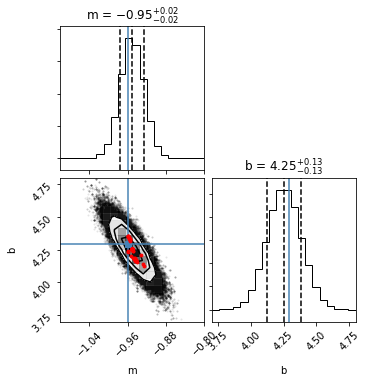

In [13]:
samples = ap.sampler.get_chain(discard=ap.iburns[-1], flat=True, thin=ap.ithins[-1])

fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], truths=[mTrue, bTrue],
                    labels=["m", "b"], show_titles=True, scale_hist=True,
                    plot_contours=True, range=([-1.1,-0.8],[3.7, 4.8]));

# Plot where forward model was evaluated
fig.axes[2].scatter(ap.theta[:,0], ap.theta[:,1], s=8, color="red", zorder=20);

The predictions are nearly identical to the true MCMC!